In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os, sys
from glob import glob
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import gaussian_filter
import h5py
import quantities as pq

sys.path.append('../scripts/')
from LPA import LPA_Signal

sys.path.append('../scripts/icsd_scripts/')
from data_processing_before_lpa import *

%config Completer.use_jedi = False

In [3]:
sim_data_dir = '/Users/atleeskelandrimehaug/Dropbox (Simula)/Data/output_sims'
fig_dir = 'Figures/test_notebooks'

In [4]:
# for plotting
plt.rcParams.update({'font.size': 16})

## Load simulation data

In [5]:
nchan_sim = 26                                          # Number of channels on probe in simulation

trial_dur_sim = 750                                     # Duration one trial (ms)
tstim_onset_sim = 250
tstim_onset_sim_dg = 500
trial_dur_sim_dg = 3000
ntrials_sim = 10                                        # Number of trials
t_rem_trial_start = 50

trial_dur_sim_corr = trial_dur_sim-t_rem_trial_start
trial_dur_sim_dg_corr = 3000-t_rem_trial_start
tstim_onset_sim = tstim_onset_sim-t_rem_trial_start
tstim_onset_sim_dg = tstim_onset_sim_dg-t_rem_trial_start

channel = np.arange(nchan_sim)

## Load simulation LFP

In [51]:
lfp_sims_all_stim = dict()

#### Flashes

In [9]:
sim_data_dir = '../data/sim_data/'

selected_sims_data_dir = os.path.join(sim_data_dir, '*full_model*')

lfp_sims = find_files(selected_sims_data_dir, filename = 'lfp_w_baseline.npy')
        
if len(lfp_sims.keys()) == 1:
    sim_name = list(lfp_sims.keys())[0]
elif len(lfp_sims.keys()) > 1:
    sim_names = list(lfp_sims.keys())
    sim_name = sim_names[0]
print(lfp_sims.keys())

lfp_sims_all_stim = dict()
    
for sim_name in list(lfp_sims.keys()):
    lfp_sims_all_stim_temp = dict()
    lfp_sims_all_stim_temp['all_trials'] = lfp_sims[sim_name]['all_trials']#[:,:,tstim_onset_sim:]
    lfp_sims_all_stim_temp['trial_avg'] = lfp_sims[sim_name]['trial_avg']#[:,tstim_onset_sim:]
    lfp_sims_all_stim[sim_name] = lfp_sims_all_stim_temp

dict_keys(['full_model_white_flash', 'full_model_black_flash'])


### Compute CSD

In [18]:
nchan_lim = 22; nstim = 2; ntime = 700

method='DeltaiCSD'

#csd_for_lpa = np.zeros((nstim, nchan, ntime))
csd_for_lpa = np.zeros((nstim, nchan_lim, ntime))

csd_sims = dict()
for isim, sim_name in enumerate(lfp_sims_all_stim.keys()):
    print(sim_name)
    lfp_temp = lfp_sims_all_stim[sim_name]['trial_avg'][:nchan_lim]
    
    csd_temp = compute_csd(lfp_temp, method = 'delta', h = 40*1E-6*pq.m, gauss_filter = (1.4,0),
                        coord_electrodes = np.linspace(0,840E-6, lfp_temp.shape[0]) * pq.m)
    
    csd_for_lpa[isim] = csd_temp
    
    csd_sims[sim_name] = csd_temp

full_model_white_flash
full_model_black_flash


# Organize model population firing rate matrix to use for decomposition

### Load spikes from flash simulations

In [23]:
timestamps_all_stim = dict()

In [24]:
timestamps_configs = find_all_fir_rates_files_sim(selected_sims_data_dir.rsplit('/', 1)[0], 'timestamps_with_neuron_ids*.npy')
sim_names = list(timestamps_configs.keys())
print(sim_names)
sim_name = sim_names[-1]

['full_model_white_flash', 'full_model_black_flash']


#### Compute population firing rates

In [25]:
npop_guess = 1

In [26]:
sims_spike_trains_cell_pops = timestamps_to_spiketrains_sim(timestamps_configs, mode = 'only_exc')


 full_model_white_flash
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
Use only excitatory cells. Skip.
i23Htr3a
Use only excitatory cells. Skip.
i23Pvalb
Use only excitatory cells. Skip.
i23Sst
Use only excitatory cells. Skip.
i4Htr3a
Use only excitatory cells. Skip.
i4Pvalb
Use only excitatory cells. Skip.
i4Sst
Use only excitatory cells. Skip.
i5Htr3a
Use only excitatory cells. Skip.
i5Pvalb
Use only excitatory cells. Skip.
i5Sst
Use only excitatory cells. Skip.
i6Htr3a
Use only excitatory cells. Skip.
i6Pvalb
Use only excitatory cells. Skip.
i6Sst
Use only excitatory cells. Skip.

 full_model_black_flash
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
Use only excitatory cells. Skip.
i23Htr3a
Use only excitatory cells. Skip.
i23Pvalb
Use only excitatory cells. Skip.
i23Sst
Use only excitatory cells. Skip.
i4Htr3a
Use only excitatory cells. Skip.
i4Pvalb
Use only excitatory cells. Skip.
i4Sst
Use only excitatory cells. Skip.
i5Htr3a


In [27]:
sims_spike_trains_layer_pops = spiketrains_by_layer(sims_spike_trains_cell_pops, npop_guess = npop_guess)

full_model_white_flash
e23Cux2 12689
e4Nr5a1 1248
e4Rorb 2605
e4Scnn1a 3072
e4other 3329
e5Rbp4 6010
e5noRbp4 1559
e6Ntsr1 12882
full_model_black_flash
e23Cux2 12689
e4Nr5a1 1248
e4Rorb 2605
e4Scnn1a 3072
e4other 3329
e5Rbp4 6010
e5noRbp4 1559
e6Ntsr1 12882


In [28]:
sims_spike_trains_layer_pops[sim_name].keys()

dict_keys(['v1'])

In [29]:
fir_rate_all_trials = dict()
fir_rate_trial_avg = dict()

fir_rate_trial_avg_pops_temp = np.zeros((len(sims_spike_trains_layer_pops.keys()), npop_guess, 700))
for isim, sim_name in enumerate(sims_spike_trains_layer_pops.keys()):
    print(sim_name)
    for ipop, pop_name in enumerate(sims_spike_trains_layer_pops[sim_name].keys()):
        print(pop_name)
        fir_rate_temp = np.mean(np.mean(sims_spike_trains_layer_pops[sim_name]\
                                            [pop_name][:,:,t_rem_trial_start:], axis = 0), axis = 0)
        
        fir_rate_trial_avg_pops_temp[isim, ipop] = fir_rate_temp
        

for ipop, pop_name in enumerate(sims_spike_trains_layer_pops[sim_name].keys()):
    print(pop_name)
    fir_rate_trial_avg[pop_name] = fir_rate_trial_avg_pops_temp[:, ipop]
    
fir_rate_all_stim_trial_avg = fir_rate_trial_avg

full_model_white_flash
v1
full_model_black_flash
v1
v1


## Load LGN input

In [35]:
fir_rate_lgn_all_stim_trial_avg = np.zeros((nstim, ntime))

#### White flash

In [36]:
model_input_path = '/Users/atleeskelandrimehaug/Repository/cobra_check/V1_model_working_dir/inputs_from_V1_model'
filename = 'lgn_exp_input_NO_ON-OFF_class_10trials_nov_15_short.h5'
loadpath = os.path.join(model_input_path, filename)
file = h5py.File(loadpath, 'r')
neuron_ids_lgn_input = np.array(file['spikes']['gids'])
timestamps_lgn_input = np.array(file['spikes']['timestamps'])
file.close()

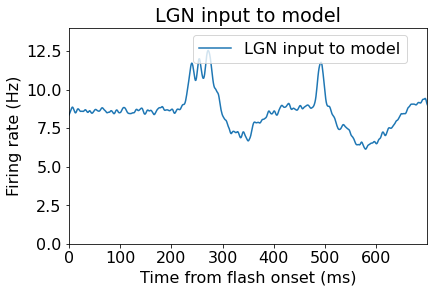

In [37]:
ntrials_sim = 10
bins_lgn = np.linspace(0, ntrials_sim*trial_dur_sim, ntrials_sim*trial_dur_sim+1)
fir_rate_lgn_input_w_flash = np.histogram(timestamps_lgn_input, bins = bins_lgn)[0]/17400
fir_rate_lgn_input_w_flash = fir_rate_lgn_input_w_flash.reshape((ntrials_sim, trial_dur_sim))
fir_rate_lgn_input_w_flash = fir_rate_lgn_input_w_flash[:,t_rem_trial_start:]
#fir_rate_lgn_input_w_flash = (fir_rate_lgn_input_w_flash.T - np.mean(fir_rate_lgn_input_w_flash[:,:tstim_onset_sim], axis=1)).T
#fir_rate_lgn_input_w_flash = fir_rate_lgn_input_w_flash[:,tstim_onset_sim:]
fir_rate_lgn_flash_plot = np.mean(fir_rate_lgn_input_w_flash, axis=0)
istim = 0
fir_rate_lgn_all_stim_trial_avg[istim] = fir_rate_lgn_flash_plot
fir_rate_lgn_flash_plot = gaussian_filter1d(fir_rate_lgn_flash_plot, sigma = 2)


fig = plt.figure(figsize = (6,4))

ax = fig.add_subplot(1,1,1)
ax.plot(fir_rate_lgn_flash_plot*1E3, color = 'tab:blue', label = 'LGN input to model')
ax.margins(x=0)
ax.set_ylim([0, 14])
ax.set_ylabel('Firing rate (Hz)')
ax.set_xlabel('Time from flash onset (ms)')
fig.legend(bbox_to_anchor = (0.96, 0.92))

ax.set_title('LGN input to model')

fig.subplots_adjust(left = 0.12, right = 0.95, bottom = 0.15, top = 0.9)

fig_name = 'lgn-input-to-model.png'

#savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w')

### Black flash

In [38]:
filename = 'lgn_black_flash_exp_input_NO_ON-OFF_class_10trials_nov_15_short.h5'
loadpath = os.path.join(model_input_path, filename)
file = h5py.File(loadpath, 'r')
neuron_ids_lgn_input = np.array(file['spikes']['gids'])
timestamps_lgn_input = np.array(file['spikes']['timestamps'])
file.close()

In [39]:
tstim_onset_sim

200

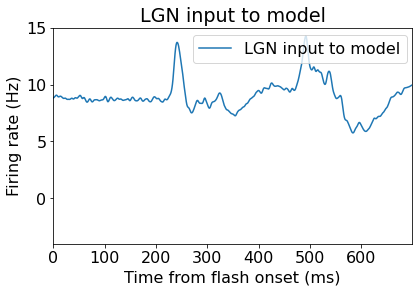

In [40]:
ntrials_sim = 10
bins_lgn = np.linspace(0, ntrials_sim*trial_dur_sim, ntrials_sim*trial_dur_sim+1)
fir_rate_lgn_input_b_flash = np.histogram(timestamps_lgn_input, bins = bins_lgn)[0]/17400
fir_rate_lgn_input_b_flash = fir_rate_lgn_input_b_flash.reshape((ntrials_sim, trial_dur_sim))
fir_rate_lgn_input_b_flash = fir_rate_lgn_input_b_flash[:,t_rem_trial_start:]
#fir_rate_lgn_input_b_flash = (fir_rate_lgn_input_b_flash.T - np.mean(fir_rate_lgn_input_b_flash[:,:tstim_onset_sim], axis=1)).T
#fir_rate_lgn_input_b_flash = fir_rate_lgn_input_b_flash[:,tstim_onset_sim:]
fir_rate_lgn_b_flash_plot = np.mean(fir_rate_lgn_input_b_flash, axis=0)
istim = 1
fir_rate_lgn_all_stim_trial_avg[istim] = fir_rate_lgn_b_flash_plot
fir_rate_lgn_b_flash_plot = gaussian_filter1d(fir_rate_lgn_b_flash_plot, sigma = 2)


fig = plt.figure(figsize = (6,4))

ax = fig.add_subplot(1,1,1)
ax.plot(fir_rate_lgn_b_flash_plot*1E3, color = 'tab:blue', label = 'LGN input to model')
ax.margins(x=0)
ax.set_ylim([-4, 15])
ax.set_ylabel('Firing rate (Hz)')
ax.set_xlabel('Time from flash onset (ms)')
fig.legend(bbox_to_anchor = (0.96, 0.92))

ax.set_title('LGN input to model')

fig.subplots_adjust(left = 0.12, right = 0.95, bottom = 0.15, top = 0.9)

fig_name = 'lgn-input-to-model.png'

#savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w')

## Load FB input

In [43]:
fir_rate_fb_all_stim_trial_avg = np.zeros((nstim, ntime))

#### White flash

In [46]:
model_input_path = '/Users/atleeskelandrimehaug/Repository/cobra_check/V1_model_working_dir/inputs_from_V1_model'
filename = 'fb_from_LM_short.h5'
loadpath = os.path.join(model_input_path, filename)
file = h5py.File(loadpath, 'r')
neuron_ids_fb_input = np.array(file['spikes']['gids'])
timestamps_fb_input = np.array(file['spikes']['timestamps'])
file.close()

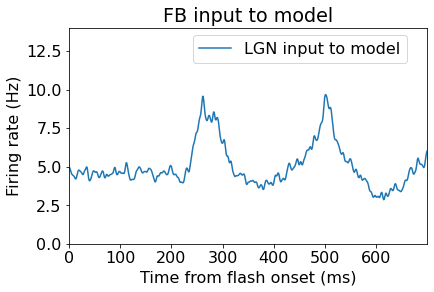

In [47]:
ntrials_sim = 10
bins_fb = np.linspace(0, ntrials_sim*trial_dur_sim, ntrials_sim*trial_dur_sim+1)
fir_rate_fb_input_w_flash = np.histogram(timestamps_fb_input, bins = bins_fb)[0]/1E3
fir_rate_fb_input_w_flash = fir_rate_fb_input_w_flash.reshape((ntrials_sim, trial_dur_sim))
fir_rate_fb_input_w_flash = fir_rate_fb_input_w_flash[:,t_rem_trial_start:]
#fir_rate_lgn_input_w_flash = (fir_rate_lgn_input_w_flash.T - np.mean(fir_rate_lgn_input_w_flash[:,:tstim_onset_sim], axis=1)).T
#fir_rate_lgn_input_w_flash = fir_rate_lgn_input_w_flash[:,tstim_onset_sim:]
fir_rate_fb_flash_plot = np.mean(fir_rate_fb_input_w_flash, axis=0)
istim = 0
fir_rate_fb_all_stim_trial_avg[istim] = fir_rate_fb_flash_plot
fir_rate_fb_flash_plot = gaussian_filter1d(fir_rate_fb_flash_plot, sigma = 2)


fig = plt.figure(figsize = (6,4))

ax = fig.add_subplot(1,1,1)
ax.plot(fir_rate_fb_flash_plot*1E3, color = 'tab:blue', label = 'LGN input to model')
ax.margins(x=0)
ax.set_ylim([0, 14])
ax.set_ylabel('Firing rate (Hz)')
ax.set_xlabel('Time from flash onset (ms)')
fig.legend(bbox_to_anchor = (0.96, 0.92))

ax.set_title('FB input to model')

fig.subplots_adjust(left = 0.12, right = 0.95, bottom = 0.15, top = 0.9)

fig_name = 'FB-input-to-model.png'

#savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w')

#### Black flash

In [48]:
model_input_path = '/Users/atleeskelandrimehaug/Repository/cobra_check/V1_model_working_dir/inputs_from_V1_model'
filename = 'fb_from_LM_black_short.h5'
loadpath = os.path.join(model_input_path, filename)
file = h5py.File(loadpath, 'r')
neuron_ids_fb_input = np.array(file['spikes']['gids'])
timestamps_fb_input = np.array(file['spikes']['timestamps'])
file.close()

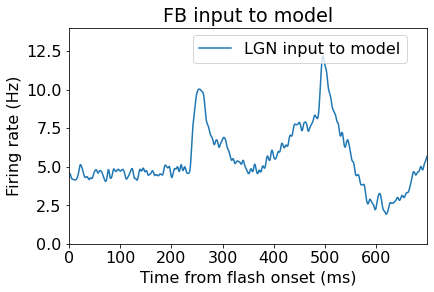

In [49]:
ntrials_sim = 10
bins_fb = np.linspace(0, ntrials_sim*trial_dur_sim, ntrials_sim*trial_dur_sim+1)
fir_rate_fb_input_w_flash = np.histogram(timestamps_fb_input, bins = bins_fb)[0]/1E3
fir_rate_fb_input_w_flash = fir_rate_fb_input_w_flash.reshape((ntrials_sim, trial_dur_sim))
fir_rate_fb_input_w_flash = fir_rate_fb_input_w_flash[:,t_rem_trial_start:]
#fir_rate_lgn_input_w_flash = (fir_rate_lgn_input_w_flash.T - np.mean(fir_rate_lgn_input_w_flash[:,:tstim_onset_sim], axis=1)).T
#fir_rate_lgn_input_w_flash = fir_rate_lgn_input_w_flash[:,tstim_onset_sim:]
fir_rate_fb_flash_plot = np.mean(fir_rate_fb_input_w_flash, axis=0)
istim = 1
fir_rate_fb_all_stim_trial_avg[istim] = fir_rate_fb_flash_plot
fir_rate_fb_flash_plot = gaussian_filter1d(fir_rate_fb_flash_plot, sigma = 2)


fig = plt.figure(figsize = (6,4))

ax = fig.add_subplot(1,1,1)
ax.plot(fir_rate_fb_flash_plot*1E3, color = 'tab:blue', label = 'LGN input to model')
ax.margins(x=0)
ax.set_ylim([0, 14])
ax.set_ylabel('Firing rate (Hz)')
ax.set_xlabel('Time from flash onset (ms)')
fig.legend(bbox_to_anchor = (0.96, 0.92))

ax.set_title('FB input to model')

fig.subplots_adjust(left = 0.12, right = 0.95, bottom = 0.15, top = 0.9)

fig_name = 'FB-input-to-model.png'

#savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w')

### Background input

In [50]:
fir_rate_bkg_all_stim_trial_avg = np.zeros((nstim, ntime))

In [51]:
model_input_path = '/Users/atleeskelandrimehaug/Repository/cobra_check/V1_model_working_dir/inputs_from_V1_model'
filename = 'bkg_nest.h5'
loadpath = os.path.join(model_input_path, filename)
file = h5py.File(loadpath, 'r')
neuron_ids_bkg_input = np.array(file['spikes']['gids'])
timestamps_bkg_input = np.array(file['spikes']['timestamps'])
file.close()

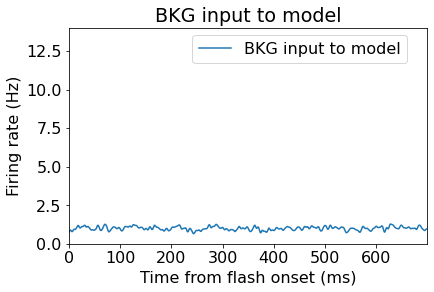

In [52]:
ntrials_sim = 10
bins_bkg = np.linspace(0, ntrials_sim*trial_dur_sim, ntrials_sim*trial_dur_sim+1)
fir_rate_bkg_input_w_flash = np.histogram(timestamps_bkg_input, bins = bins_bkg)[0]/1E3
fir_rate_bkg_input_w_flash = fir_rate_bkg_input_w_flash.reshape((ntrials_sim, trial_dur_sim))
fir_rate_bkg_input_w_flash = fir_rate_bkg_input_w_flash[:,t_rem_trial_start:]
#fir_rate_lgn_input_w_flash = (fir_rate_lgn_input_w_flash.T - np.mean(fir_rate_lgn_input_w_flash[:,:tstim_onset_sim], axis=1)).T
#fir_rate_lgn_input_w_flash = fir_rate_lgn_input_w_flash[:,tstim_onset_sim:]
fir_rate_bkg_flash_plot = np.mean(fir_rate_bkg_input_w_flash, axis=0)
for istim in range(2):
    fir_rate_bkg_all_stim_trial_avg[istim] = fir_rate_bkg_flash_plot

fir_rate_bkg_flash_plot = gaussian_filter1d(fir_rate_bkg_flash_plot, sigma = 2)


fig = plt.figure(figsize = (6,4))

ax = fig.add_subplot(1,1,1)
ax.plot(fir_rate_bkg_flash_plot*1E3, color = 'tab:blue', label = 'BKG input to model')
ax.margins(x=0)
ax.set_ylim([0, 14])
ax.set_ylabel('Firing rate (Hz)')
ax.set_xlabel('Time from flash onset (ms)')
fig.legend(bbox_to_anchor = (0.96, 0.92))

ax.set_title('BKG input to model')

fig.subplots_adjust(left = 0.12, right = 0.95, bottom = 0.15, top = 0.9)

fig_name = 'BKG-input-to-model.png'

#savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w')

In [54]:
rmat_model_w_lgn_fb = np.zeros((nstim, fir_rate_lgn_all_stim_trial_avg.shape[1], npop_guess+3))
rmat_model_w_lgn_fb[:, :, 0] = fir_rate_lgn_all_stim_trial_avg

for ipop, pop_name in enumerate(fir_rate_all_stim_trial_avg.keys()):
    rmat_model_w_lgn_fb[:, :, 1+ipop] = fir_rate_all_stim_trial_avg[pop_name]
    
rmat_model_w_lgn_fb[:, :, -2] = fir_rate_fb_all_stim_trial_avg
rmat_model_w_lgn_fb[:, :, -1] = fir_rate_bkg_all_stim_trial_avg

In [56]:
rmat_model_w_lgn_fb.shape

(2, 700, 4)

# Organize population firing rate matrix with LPA estimated temporal profiles to use for decomposition

### Load firing rate temporal profiles estimated from LPA

In [58]:
npop_guess = 1

In [60]:
loadpath = '../make_figures_article/lpa_results_data/test_notebooks'

filename = 'lpa_results_applied_to_full_model_sim_w_'+str(npop_guess)+'_pop.npy'

loadpath = os.path.join(loadpath,filename)

lpa_results = np.load(loadpath, allow_pickle = True)[()]

# Est. spatial profiles of laminar populations
rmat_lpa = lpa_results['rmat_lpa']

In [61]:
rmat_lpa.shape

(2, 700, 1)

### Put the LPA-est. temporal profiles together with firing rates of model external input in matrix to use in decomposition

In [85]:
rmat_lpa_w_lgn_fb = np.zeros((rmat_lpa.shape[:2]+(rmat_lpa.shape[-1]+3,)))
rmat_lpa_w_lgn_fb[:, :, 0] = fir_rate_lgn_all_stim_trial_avg
rmat_lpa_w_lgn_fb[:,:,1:-2] = rmat_lpa
rmat_lpa_w_lgn_fb[:, :, -2] = fir_rate_fb_all_stim_trial_avg
rmat_lpa_w_lgn_fb[:, :, -1] = fir_rate_bkg_all_stim_trial_avg

In [86]:
rmat_lpa_w_lgn_fb.shape

(2, 700, 4)

#### Plot to check matrix with temporal profiles estimated from LPA

Text(0, 0.5, 'a.u.')

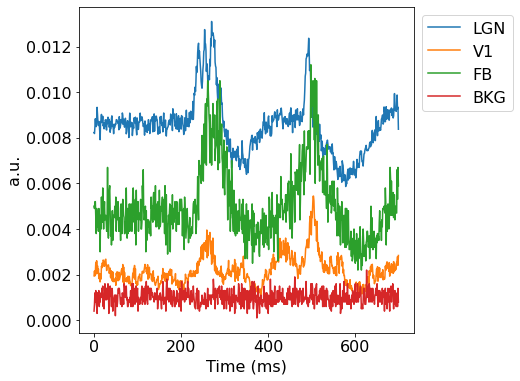

In [88]:
pop_names = ['LGN', 'V1', 'FB', 'BKG']

istim = 0
fig, ax = plt.subplots(figsize = (6,6))
for ipop in range(rmat_lpa_w_lgn_fb.shape[-1]):
    fir_rate_plot = rmat_lpa_w_lgn_fb[istim,:,ipop]
    #fir_rate_plot = gaussian_filter1d(fir_rate_plot*1E3, sigma = 2)
    
    ax.plot(fir_rate_plot, label = pop_names[ipop])
    
ax.legend(bbox_to_anchor = (1,1))

ax.set_xlabel('Time (ms)')
ax.set_ylabel('a.u.')

ax.set_title('Temporal profiles of presynaptic firing rates')

In [65]:
subtract_baseline = True
baseline_presubtracted_lfp = False
if subtract_baseline:
    baseline_end = 200
    baseline_string = 'baseline_subtracted'
else:
    baseline_end = 0
    if baseline_presubtracted_lfp:
        baseline_string = 'baseline_pre_subtracted'
        baseline_end_fir_rates = 250
    else:
        baseline_string = 'w_baseline'

In [68]:
nchan = nchan_lim

In [70]:
# loading the underlying data matrix and define names
#LOADNAME = 'testdata.mat'
CASENAME = 'lfp_sim_w_LGN_input_and_v1v1_connects_modified'

#DATA = loadmat(LOADNAME)
SETNAME_MUA = 'mua'
SETNAME_LFP = 'lfp'

nstim = 2
LFP = np.zeros((nstim, ntime, nchan))
CSD = np.zeros((nstim, ntime, nchan))
print(CSD.shape)
for istim in range(CSD.shape[0]):
    LFP[istim] = lfp_for_lpa[istim].T
    CSD[istim] = csd_for_lpa[istim].T
    #CSD[istim] = csd_sum_gt[istim].T
MUA = np.zeros_like(CSD)#MUA[:,t_start:t_stop]

###################################################################
# initializing the LPA_signal

nstim, ntime, nchan = CSD.shape

z_start = 0.   # depth of first electrode in mm
z_space = 0.04  # electrode spacing in mm

S_dict = {
    'mua_data' : MUA,
    'lfp_data' : CSD,
    'dt' : 1,
    'z_start' : z_start,
    'z_space' : z_space,
    'casename' : CASENAME,
    'tstim' : baseline_end,
    'sub_at' : 'base', # 
    'verbose' : True
    }

lpa_signal = LPA_Signal(**S_dict)

####################################################################
# Initial guess

#npop_guess = 4

#pos_pops = np.zeros(3*npop)

#x0 = np.zeros(12)
#x0[:npop] = [0.4, 0.7, 0.95, 1.4] # Lateral position of populations (mm)
#x0[npop:2*npop] = [0.1, 0.1, 0.1, 0.1] # Width of populations
#x0[2*npop:] = [0.1, 0.1, 0.1, 0.1] # Slope of populations

####################################################################
# set up arguments for solving

maxpos = z_start + (nchan - 1) * z_space
maxpopwidth = 0.7
maxslopewidth = z_space

# lower bounds
lb = npop_guess * [z_start]# + 2 * npop_guess * [0]
print('lb = ', lb)
# upper bounds
ub = npop_guess * [maxpos] + npop_guess * [maxpopwidth] # + npop_guess * [maxslopewidth]
print('ub = ', ub)

# put any arguments passed to the initialization of the solver here,
# see documentation for openopt.NLP for details.
init_args = {
     'maxIter' : 10000,
     'maxFunEvals' : 20000,
     'maxTime' : 600,
     'maxCPUTime' : 1000,
     'maxNonSuccess' : 30
    }

# There are also some additional arguments that could be passed to the
# call function of the solver, but most of this will be handled inside
# the call function for lpa_signal (like *x0* and *plot*)
solve_args = {}

# If you subclassed LPA_Signal() and wrote your own error function
# that needs additional arguments, you can put it in the *f_args*
# tuple. Remember that the first argument to the error function is
# always the parameters to be fitted, but this is handled under the
# hood. Only additional (only positional) arguments goes into *f_args*
f_args = ()

#############################################################
# Load results from example1_mua.py

# rmat and MPhi does not belong in lpa_signal, just put it there for
# safekeeping.
#rmat = lpa_signal.rmat
#Mphi = lpa_signal.Mphi
#del lpa_signal.rmat
#del lpa_signal.Mphi


###########################################################
# Set up arguments for solving lfp

use_model_fir_rates = True
include_lgn = True
if use_model_fir_rates:
    if include_lgn:
        print('Here')
        rmat = rmat_model_w_lgn_fb#[:1]
        lgn_string = 'w_lgn_and_fb'
    else:
        rmat = np.zeros((1,) + np.array(list(fir_rate_all_stim_trial_avg.values())).T.shape)
        rmat[0] = np.array(list(fir_rate_all_stim_trial_avg.values())).T
        lgn_string = 'wo_lgn'
    fir_rate_decomp_string = 'decomp_w_mod_fir_rates'
else:
    if include_lgn:
        rmat = rmat_lpa_w_lgn_fb
        lgn_string = 'w_lgn_and_fb'
    else:
        rmat = rmat_lpa
        lgn_string = 'wo_lgn'
    fir_rate_decomp_string = 'decomp_w_lpa_fir_rates'
        
if subtract_baseline:
    for istim in range(rmat.shape[0]):
        rmat[istim] = rmat[istim] - np.mean(rmat[istim,:baseline_end], axis = 0)
        
if rmat.shape[-1] > 3:
    fir_rate_decomp_string = fir_rate_decomp_string + '_w_bkg'
        
        
#for 
kernel = 'uniqueKernelsExp'
#kernel = 'singleExp'

for ipop in range(rmat.shape[-1]):
    if ipop == 0:
        t_kernelParams = [5,5]#,1]
        lb = [4,0]#,1E-3]
        ub = [20,10]#,10]
    else:
        t_kernelParams = np.concatenate([t_kernelParams, [5,5]])#1]])
        lb = np.concatenate([lb, [4,0]])#,1E-3]])
        ub = np.concatenate([ub, [20,10]])#,10]])
    
# these dicts are explained in example1_mua.py
#init_args = {}
solve_args = {}      
    
#if np.logical_and(subtract_baseline or baseline_presubtracted_lfp, use_model_fir_rates):
#    for ipop in range(rmat.shape[-1]):
#        for istim in range(rmat.shape[0]):
#            rmat[istim] -= np.mean(rmat[istim,:baseline_end_fir_rates,ipop])

f_args = (rmat, kernel)
###############################################################
# Solve lfp
print('init_args: ', init_args)
solve_dict = {
    'init_args' : init_args,
    'solve_args' : solve_args,
    'f_args' : f_args,
    'plot' : False,
    }

mode = 'lfp'
solver = 'de'

pen_fac_dev_from_0 = 0

err_wo_pen_dict = dict()
Cmat_lpa_dict = dict()
Rmat_lpa_dict = dict()
Cphi_lpa_dict = dict()
h_list_dict = dict()
tau_lpa_dict = dict()
delta_lpa_dict = dict()


# loop through each penalty factor term
for pen_fac_dev_from_0 in np.arange(0, 10, 0.5):

    r_lpa_LFP, Cmat_lpa, Rmat_lpa, Cphi_lpa, h_list, err_wo_pen, tau, delta = lpa_signal(mode, solver, t_kernelParams, lb, ub, pen_fac = pen_fac_dev_from_0, **solve_dict)

    err_wo_pen_dict[pen_fac_dev_from_0] = err_wo_pen


    Cmat_lpa_dict[pen_fac_dev_from_0] = Cmat_lpa
    Rmat_lpa_dict[pen_fac_dev_from_0] = Rmat_lpa
    Cphi_lpa_dict[pen_fac_dev_from_0] = Cphi_lpa
    h_list_dict[pen_fac_dev_from_0] = h_list
    tau_lpa_dict[pen_fac_dev_from_0] = tau
    delta_lpa_dict[pen_fac_dev_from_0] = delta

(2, 700, 22)
This is class *LPA_Signal* in *pyLPA* module
lb =  [0.0]
ub =  [0.84, 0.7]
Here
init_args:  {'maxIter': 10000, 'maxFunEvals': 20000, 'maxTime': 600, 'maxCPUTime': 1000, 'maxNonSuccess': 30}
Solving for lfp part of signal
len(ub):  8
self.pen_fac:  0.0

------------------------- OpenOpt 0.5629 -------------------------
problem: unnamed   type: GLP    goal: minimum
solver: de
variables: 8
  iter  objFunVal  
    0  2.699e-01 
   10  2.189e-01 
   20  2.179e-01 
   30  2.161e-01 
   40  2.157e-01 
   50  2.155e-01 
   60  2.154e-01 
   70  2.152e-01 
   80  2.151e-01 
   90  2.151e-01 
  100  2.151e-01 
  110  2.151e-01 
  120  2.151e-01 
  130  2.151e-01 
  140  2.151e-01 
  150  2.151e-01 
  160  2.151e-01 
  170  2.151e-01 
  180  2.151e-01 
  190  2.151e-01 
  200  2.151e-01 
  210  2.151e-01 
  220  2.151e-01 
  230  2.151e-01 
  240  2.151e-01 
  247  2.151e-01 
istop: -10 (max objfunc evals limit (p.maxFunEvals=20000) has been reached)
Solver:   Time Elapsed = 24.6  	C

   10  3.733e+00 
   20  3.371e+00 
   30  3.348e+00 
   40  3.022e+00 
   50  3.022e+00 
   60  2.959e+00 
   70  2.615e+00 
   80  2.615e+00 
   90  2.615e+00 
   98  2.615e+00 
istop: 11 (Non-Success Number > maxNonSuccess = 30)
Solver:   Time Elapsed = 9.72  	CPU Time Elapsed = 9.71
objFuncValue: 2.6145316 (feasible, MaxResidual = 0)
Solving for lfp part of signal
len(ub):  8
self.pen_fac:  6.5

------------------------- OpenOpt 0.5629 -------------------------
problem: unnamed   type: GLP    goal: minimum
solver: de
variables: 8
  iter  objFunVal  
    0  1.038e+01 
   10  4.021e+00 
   20  3.623e+00 
   30  3.599e+00 
   40  3.245e+00 
   50  3.245e+00 
   60  3.177e+00 
   70  2.803e+00 
   80  2.803e+00 
   90  2.803e+00 
   98  2.803e+00 
istop: 11 (Non-Success Number > maxNonSuccess = 30)
Solver:   Time Elapsed = 9.66  	CPU Time Elapsed = 9.65
objFuncValue: 2.8032046 (feasible, MaxResidual = 0)
Solving for lfp part of signal
len(ub):  8
self.pen_fac:  7.0

-------------------

### Save results from LPA application to CSD

In [74]:
lpa_results = dict()

# LPA-estimated CSD
lpa_results['Cphi'] = Cphi_lpa_dict

# Est. temporal profiles of postsynaptic LFP
lpa_results['Rmat'] = Rmat_lpa_dict

# Est. spatial profiles of laminar populations
lpa_results['Cmat'] = Cmat_lpa_dict

# MSE of estimate without penalty term
lpa_results['err_wo_pen'] = err_wo_pen_dict

# time constant for optimized kernels
lpa_results['tau'] = tau_lpa_dict

# delay for optimized kernels
lpa_results['delta'] = delta_lpa_dict

# list of penalty factors utilized
lpa_results['penalty_factor'] = np.array(list(Cmat_lpa_dict.keys()))

In [77]:
savepath = '../make_figures_article/lpa_results_data/test_notebooks'

if not os.path.exists(savepath):
    os.mkdir(savepath)

filename = 'CSD_lpa_results_applied_to_full_model_sim_w_'+str(npop_guess)+'_pop.npy'

savepath = os.path.join(savepath,filename)

#np.save(savepath, lpa_results)